In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import os

/Users/xiejiayu/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import gen_image_ops
from tensorflow.python.ops import gen_nn_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import string_ops
from tensorflow.python.ops import variables

def _verify_compatible_image_shapes(img1, img2):
  """Checks if two image tensors are compatible for applying SSIM or PSNR.
  This function checks if two sets of images have ranks at least 3, and if the
  last three dimensions match.
  Args:
    img1: Tensor containing the first image batch.
    img2: Tensor containing the second image batch.
  Returns:
    A tuple containing: the first tensor shape, the second tensor shape, and a
    list of control_flow_ops.Assert() ops implementing the checks.
  Raises:
    ValueError: When static shape check fails.
  """
  shape1 = img1.get_shape().with_rank_at_least(3)
  shape2 = img2.get_shape().with_rank_at_least(3)
  shape1[-3:].assert_is_compatible_with(shape2[-3:])

  if shape1.ndims is not None and shape2.ndims is not None:
    for dim1, dim2 in zip(reversed(shape1[:-3]), reversed(shape2[:-3])):
      if not (dim1 == 1 or dim2 == 1 or dim1.is_compatible_with(dim2)):
        raise ValueError(
            'Two images are not compatible: %s and %s' % (shape1, shape2))

  # Now assign shape tensors.
  shape1, shape2 = array_ops.shape_n([img1, img2])

  # TODO(sjhwang): Check if shape1[:-3] and shape2[:-3] are broadcastable.
  checks = []
  checks.append(control_flow_ops.Assert(
      math_ops.greater_equal(array_ops.size(shape1), 3),
      [shape1, shape2], summarize=10))
  checks.append(control_flow_ops.Assert(
      math_ops.reduce_all(math_ops.equal(shape1[-3:], shape2[-3:])),
      [shape1, shape2], summarize=10))
  return shape1, shape2, checks


# @tf_export('image.psnr')
def psnr(a, b, max_val, name=None):
  """Returns the Peak Signal-to-Noise Ratio between a and b.
  This is intended to be used on signals (or images). Produces a PSNR value for
  each image in batch.
  The last three dimensions of input are expected to be [height, width, depth].
  Example:
  ```python
      # Read images from file.
      im1 = tf.decode_png('path/to/im1.png')
      im2 = tf.decode_png('path/to/im2.png')
      # Compute PSNR over tf.uint8 Tensors.
      psnr1 = tf.image.psnr(im1, im2, max_val=255)
      # Compute PSNR over tf.float32 Tensors.
      im1 = tf.image.convert_image_dtype(im1, tf.float32)
      im2 = tf.image.convert_image_dtype(im2, tf.float32)
      psnr2 = tf.image.psnr(im1, im2, max_val=1.0)
      # psnr1 and psnr2 both have type tf.float32 and are almost equal.
  ```
  Arguments:
    a: First set of images.
    b: Second set of images.
    max_val: The dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    name: Namespace to embed the computation in.
  Returns:
    The scalar PSNR between a and b. The returned tensor has type `tf.float32`
    and shape [batch_size, 1].
  """
  with ops.name_scope(name, 'PSNR', [a, b]):
    # Need to convert the images to float32.  Scale max_val accordingly so that
    # PSNR is computed correctly.
    max_val = math_ops.cast(max_val, a.dtype)
    max_val = convert_image_dtype(max_val, dtypes.float32)
    a = convert_image_dtype(a, dtypes.float32)
    b = convert_image_dtype(b, dtypes.float32)
    mse = math_ops.reduce_mean(math_ops.squared_difference(a, b), [-3, -2, -1])
    psnr_val = math_ops.subtract(
        20 * math_ops.log(max_val) / math_ops.log(10.0),
        np.float32(10 / np.log(10)) * math_ops.log(mse),
        name='psnr')

    _, _, checks = _verify_compatible_image_shapes(a, b)
    with ops.control_dependencies(checks):
      return array_ops.identity(psnr_val)

_SSIM_K1 = 0.01
_SSIM_K2 = 0.03


def _ssim_helper(x, y, reducer, max_val, compensation=1.0):
  r"""Helper function for computing SSIM.
  SSIM estimates covariances with weighted sums.  The default parameters
  use a biased estimate of the covariance:
  Suppose `reducer` is a weighted sum, then the mean estimators are
    \mu_x = \sum_i w_i x_i,
    \mu_y = \sum_i w_i y_i,
  where w_i's are the weighted-sum weights, and covariance estimator is
    cov_{xy} = \sum_i w_i (x_i - \mu_x) (y_i - \mu_y)
  with assumption \sum_i w_i = 1. This covariance estimator is biased, since
    E[cov_{xy}] = (1 - \sum_i w_i ^ 2) Cov(X, Y).
  For SSIM measure with unbiased covariance estimators, pass as `compensation`
  argument (1 - \sum_i w_i ^ 2).
  Arguments:
    x: First set of images.
    y: Second set of images.
    reducer: Function that computes 'local' averages from set of images.
      For non-covolutional version, this is usually tf.reduce_mean(x, [1, 2]),
      and for convolutional version, this is usually tf.nn.avg_pool or
      tf.nn.conv2d with weighted-sum kernel.
    max_val: The dynamic range (i.e., the difference between the maximum
      possible allowed value and the minimum allowed value).
    compensation: Compensation factor. See above.
  Returns:
    A pair containing the luminance measure, and the contrast-structure measure.
  """
  c1 = (_SSIM_K1 * max_val) ** 2
  c2 = (_SSIM_K2 * max_val) ** 2

  # SSIM luminance measure is
  # (2 * mu_x * mu_y + c1) / (mu_x ** 2 + mu_y ** 2 + c1).
  mean0 = reducer(x)
  mean1 = reducer(y)
  num0 = mean0 * mean1 * 2.0
  den0 = math_ops.square(mean0) + math_ops.square(mean1)
  luminance = (num0 + c1) / (den0 + c1)

  # SSIM contrast-structure measure is
  #   (2 * cov_{xy} + c2) / (cov_{xx} + cov_{yy} + c2).
  # Note that `reducer` is a weighted sum with weight w_k, \sum_i w_i = 1, then
  #   cov_{xy} = \sum_i w_i (x_i - \mu_x) (y_i - \mu_y)
  #          = \sum_i w_i x_i y_i - (\sum_i w_i x_i) (\sum_j w_j y_j).
  num1 = reducer(x * y) * 2.0
  den1 = reducer(math_ops.square(x) + math_ops.square(y))
  c2 *= compensation
  cs = (num1 - num0 + c2) / (den1 - den0 + c2)

  # SSIM score is the product of the luminance and contrast-structure measures.
  return luminance, cs


def _fspecial_gauss(size, sigma):
  """Function to mimic the 'fspecial' gaussian MATLAB function."""
  size = ops.convert_to_tensor(size, dtypes.int32)
  sigma = ops.convert_to_tensor(sigma)

  coords = math_ops.cast(math_ops.range(size), sigma.dtype)
  coords -= math_ops.cast(size - 1, sigma.dtype) / 2.0

  g = math_ops.square(coords)
  g *= -0.5 / math_ops.square(sigma)

  g = array_ops.reshape(g, shape=[1, -1]) + array_ops.reshape(g, shape=[-1, 1])
  g = array_ops.reshape(g, shape=[1, -1])  # For tf.nn.softmax().
  g = nn_ops.softmax(g)
  return array_ops.reshape(g, shape=[size, size, 1, 1])


def _ssim_per_channel(img1, img2, max_val=1.0):
  """Computes SSIM index between img1 and img2 per color channel.
  This function matches the standard SSIM implementation from:
  Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image
  quality assessment: from error visibility to structural similarity. IEEE
  transactions on image processing.
  Details:
    - 11x11 Gaussian filter of width 1.5 is used.
    - k1 = 0.01, k2 = 0.03 as in the original paper.
  Args:
    img1: First image batch.
    img2: Second image batch.
    max_val: The dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
  Returns:
    A pair of tensors containing and channel-wise SSIM and contrast-structure
    values. The shape is [..., channels].
  """
  filter_size = constant_op.constant(11, dtype=dtypes.int32)
  filter_sigma = constant_op.constant(1.5, dtype=img1.dtype)

  shape1, shape2 = array_ops.shape_n([img1, img2])
  checks = [
      control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(
          shape1[-3:-1], filter_size)), [shape1, filter_size], summarize=8),
      control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(
          shape2[-3:-1], filter_size)), [shape2, filter_size], summarize=8)]

  # Enforce the check to run before computation.
  with ops.control_dependencies(checks):
    img1 = array_ops.identity(img1)

  # TODO(sjhwang): Try to cache kernels and compensation factor.
  kernel = _fspecial_gauss(filter_size, filter_sigma)
  kernel = array_ops.tile(kernel, multiples=[1, 1, shape1[-1], 1])

  # The correct compensation factor is `1.0 - tf.reduce_sum(tf.square(kernel))`,
  # but to match MATLAB implementation of MS-SSIM, we use 1.0 instead.
  compensation = 1.0

  # TODO(sjhwang): Try FFT.
  # TODO(sjhwang): Gaussian kernel is separable in space. Consider applying
  #   1-by-n and n-by-1 Gaussain filters instead of an n-by-n filter.
  def reducer(x):
    shape = array_ops.shape(x)
    x = array_ops.reshape(x, shape=array_ops.concat([[-1], shape[-3:]], 0))
    y = nn.depthwise_conv2d(x, kernel, strides=[1, 1, 1, 1], padding='VALID')
    return array_ops.reshape(y, array_ops.concat([shape[:-3],
                                                  array_ops.shape(y)[1:]], 0))

  luminance, cs = _ssim_helper(img1, img2, reducer, max_val, compensation)

  # Average over the second and the third from the last: height, width.
  axes = constant_op.constant([-3, -2], dtype=dtypes.int32)
  ssim_val = math_ops.reduce_mean(luminance * cs, axes)
  cs = math_ops.reduce_mean(cs, axes)
  return ssim_val, cs


# @tf_export('image.ssim')
def ssim(img1, img2, max_val):
  """Computes SSIM index between img1 and img2.
  This function is based on the standard SSIM implementation from:
  Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image
  quality assessment: from error visibility to structural similarity. IEEE
  transactions on image processing.
  Note: The true SSIM is only defined on grayscale.  This function does not
  perform any colorspace transform.  (If input is already YUV, then it will
  compute YUV SSIM average.)
  Details:
    - 11x11 Gaussian filter of width 1.5 is used.
    - k1 = 0.01, k2 = 0.03 as in the original paper.
  The image sizes must be at least 11x11 because of the filter size.
  Example:
  ```python
      # Read images from file.
      im1 = tf.decode_png('path/to/im1.png')
      im2 = tf.decode_png('path/to/im2.png')
      # Compute SSIM over tf.uint8 Tensors.
      ssim1 = tf.image.ssim(im1, im2, max_val=255)
      # Compute SSIM over tf.float32 Tensors.
      im1 = tf.image.convert_image_dtype(im1, tf.float32)
      im2 = tf.image.convert_image_dtype(im2, tf.float32)
      ssim2 = tf.image.ssim(im1, im2, max_val=1.0)
      # ssim1 and ssim2 both have type tf.float32 and are almost equal.
  ```
  Args:
    img1: First image batch.
    img2: Second image batch.
    max_val: The dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
  Returns:
    A tensor containing an SSIM value for each image in batch.  Returned SSIM
    values are in range (-1, 1], when pixel values are non-negative. Returns
    a tensor with shape: broadcast(img1.shape[:-3], img2.shape[:-3]).
  """
  _, _, checks = _verify_compatible_image_shapes(img1, img2)
  with ops.control_dependencies(checks):
    img1 = array_ops.identity(img1)

  # Need to convert the images to float32.  Scale max_val accordingly so that
  # SSIM is computed correctly.
  max_val = math_ops.cast(max_val, img1.dtype)
  max_val = convert_image_dtype(max_val, dtypes.float32)
  img1 = convert_image_dtype(img1, dtypes.float32)
  img2 = convert_image_dtype(img2, dtypes.float32)
  ssim_per_channel, _ = _ssim_per_channel(img1, img2, max_val)
  # Compute average over color channels.
  return math_ops.reduce_mean(ssim_per_channel, [-1])

def convert_image_dtype(image, dtype, saturate=False, name=None):
  """Convert `image` to `dtype`, scaling its values if needed.
  Images that are represented using floating point values are expected to have
  values in the range [0,1). Image data stored in integer data types are
  expected to have values in the range `[0,MAX]`, where `MAX` is the largest
  positive representable number for the data type.
  This op converts between data types, scaling the values appropriately before
  casting.
  Note that converting from floating point inputs to integer types may lead to
  over/underflow problems. Set saturate to `True` to avoid such problem in
  problematic conversions. If enabled, saturation will clip the output into the
  allowed range before performing a potentially dangerous cast (and only before
  performing such a cast, i.e., when casting from a floating point to an integer
  type, and when casting from a signed to an unsigned type; `saturate` has no
  effect on casts between floats, or on casts that increase the type's range).
  Args:
    image: An image.
    dtype: A `DType` to convert `image` to.
    saturate: If `True`, clip the input before casting (if necessary).
    name: A name for this operation (optional).
  Returns:
    `image`, converted to `dtype`.
  """
  image = ops.convert_to_tensor(image, name='image')
  if dtype == image.dtype:
    return array_ops.identity(image, name=name)

  with ops.name_scope(name, 'convert_image', [image]) as name:
    # Both integer: use integer multiplication in the larger range
    if image.dtype.is_integer and dtype.is_integer:
      scale_in = image.dtype.max
      scale_out = dtype.max
      if scale_in > scale_out:
        # Scaling down, scale first, then cast. The scaling factor will
        # cause in.max to be mapped to above out.max but below out.max+1,
        # so that the output is safely in the supported range.
        scale = (scale_in + 1) // (scale_out + 1)
        scaled = math_ops.div(image, scale)

        if saturate:
          return math_ops.saturate_cast(scaled, dtype, name=name)
        else:
          return math_ops.cast(scaled, dtype, name=name)
      else:
        # Scaling up, cast first, then scale. The scale will not map in.max to
        # out.max, but converting back and forth should result in no change.
        if saturate:
          cast = math_ops.saturate_cast(image, dtype)
        else:
          cast = math_ops.cast(image, dtype)
        scale = (scale_out + 1) // (scale_in + 1)
        return math_ops.multiply(cast, scale, name=name)
    elif image.dtype.is_floating and dtype.is_floating:
      # Both float: Just cast, no possible overflows in the allowed ranges.
      # Note: We're ignoreing float overflows. If your image dynamic range
      # exceeds float range you're on your own.
      return math_ops.cast(image, dtype, name=name)
    else:
      if image.dtype.is_integer:
        # Converting to float: first cast, then scale. No saturation possible.
        cast = math_ops.cast(image, dtype)
        scale = 1. / image.dtype.max
        return math_ops.multiply(cast, scale, name=name)
      else:
        # Converting from float: first scale, then cast
        scale = dtype.max + 0.5  # avoid rounding problems in the cast
        scaled = math_ops.multiply(image, scale)
        if saturate:
          return math_ops.saturate_cast(scaled, dtype, name=name)
        else:
          return math_ops.cast(scaled, dtype, name=name)

In [4]:

def random_like(matrix):
    ## return a random float ndarray in [0,1) with the same shape like input matrix. 
    ## Input : 
    ##    matrix: numpy ndarray
    ## Output :
    ##    out: numpy float ndarray in [0,1) 
    
    return np.random.random(np.shape(matrix))

def add_impulsive_noise(image,p = 0.1 ,show_p = False):
    ## Add impulsive noise with probability p
    ## Input : 
    ##    image: numpy ndarray
    ##    p: float in (0,1), the noise probability
    ## Output :
    ##    out: numpy ndarray 
    
    if show_p:
        print (p)
    random_image = random_like(image)
    salt_position = np.where(random_image <= p/2 )
    pepper_position = np.where((random_image > p/2) & (random_image <= p))
    noise_image = np.copy(image)
    noise_image[salt_position] = 255
    noise_image[pepper_position] = 0
    return noise_image

def load_image(filepath):
    im = Image.open(filepath)
    return im

def pil2array(image):
    return np.array(image,dtype='float32')

def array2pil(array):
    im = Image.fromarray(np.uint8(array))
    return im

def PSNR(im_label,im_correct):
    im_label = np.asarray(im_label,dtype="float32")
    im_correct = np.asarray(im_correct,dtype="float32")
    MSE = np.mean(np.square(im_label-im_correct))
    return 20*np.log10(255) - 10*np.log10(MSE)

In [275]:
class Preprocess():
    def __init__(self,file_path,img_size=[180,180]):
        self.im_train_list = []
        for root, dirs, files in os.walk(file_path):  
            for file in files:
                if file.split('.')[-1] == 'png':
                    im = load_image(root+'/'+file)
                    self.im_train_list.append(pil2array(im.resize(img_size)))
        self.im_size = self.im_train_list[0].shape
        
    def next_train_batch(self,batch_size=32,show_p=False):
        train_x = []
        train_y = []
        for i in range(batch_size):
            p = np.random.rand(1)/1.25
            n = np.random.randint(len(self.im_train_list))
            train_x.append(np.expand_dims(add_impulsive_noise(self.im_train_list[n],p,show_p=show_p),axis=0))
            train_y.append(np.expand_dims(self.im_train_list[n],axis=0))
        return np.vstack(train_x),np.vstack(train_y)
    
    def test_batch(self):
        train_x = []
        train_y = []
        for i in range(len(self.im_train_list)-2):
#             for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            for p in [0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2]:
#                 p = p/1.25
                train_x.append(np.expand_dims(add_impulsive_noise(self.im_train_list[i],p,show_p=False),axis=0))
                train_y.append(np.expand_dims(self.im_train_list[i],axis=0))
        return np.vstack(train_x),np.vstack(train_y)
        

In [6]:
pre = Preprocess('./train400',[92,92])

In [7]:
class SimpleGANmodel():
    def _generator(self,x_reshaped):
        conv1_res = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[1, 1],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_1_res_conv")

        conv1 = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_1_conv")

        conv1_5 = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[5, 5],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_1_5_conv")

        conv1_5_res = tf.layers.conv2d(
                  inputs=conv1_5,
                  filters=32,
                  kernel_size=[1, 1],
                  padding="same",
                  activation=tf.nn.tanh,
                  name="g_1_5_res_conv")

        conv1_7 = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[7, 7],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_1_7_conv")

        conv1_7_res = tf.layers.conv2d(
                  inputs=conv1_7,
                  filters=32,
                  kernel_size=[1, 1],
                  padding="same",
                  activation=tf.nn.tanh,
                  name="g_1_7_res_conv")

        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        conv2 = tf.layers.conv2d(
                  inputs=pool1,
                  filters=64,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_2_conv")

        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        conv3 = tf.layers.conv2d(
                  inputs=pool2,
                  filters=128,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_3_conv")

        conv3_up = tf.layers.conv2d_transpose(
                    inputs=conv3,
                    filters=64,
                    kernel_size=[2, 2],
                    padding="valid",
                    strides=(2, 2),
                    activation=tf.nn.relu,
                    name="g_3_up_conv"
                )

        conv4 = tf.layers.conv2d(
                  inputs=tf.concat([conv2,conv3_up],axis=-1),
                  filters=64,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_4_conv")

        conv4_up = tf.layers.conv2d_transpose(
                    inputs=conv4,
                    filters=32,
                    kernel_size=[2, 2],
                    padding="valid",
                    strides=(2, 2),
                    activation=tf.nn.relu,
                    name="g_4_up_conv"
                )

        conv5 = tf.layers.conv2d(
                  inputs=tf.concat([conv4_up,conv1],axis=-1),
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_5_conv")

        conv6 = tf.layers.conv2d(
                  inputs=conv5 + conv1_res + conv1_5_res + conv1_7_res,
                  filters=1,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_6_conv")
        
        return conv6
    
    def _condition_descriminator(self,g,x,reuse=False):
        conv_g = tf.layers.conv2d(
                    inputs=g,
                    filters=32,
                    kernel_size=[3, 3],
                    padding="same",
                    activation=tf.nn.tanh,
                    name="cd_1_conv_g",
                    reuse=reuse)
        
        conv_g = tf.layers.max_pooling2d(inputs=conv_g, pool_size=[2, 2], strides=2)
        
        conv_g = tf.layers.conv2d(
                    inputs=conv_g,
                    filters=64,
                    kernel_size=[5, 5],
                    padding="same",
                    activation=tf.nn.tanh,
                    name="cd_2_conv_g",
                    reuse=reuse)
        
        conv_g = tf.layers.max_pooling2d(inputs=conv_g, pool_size=[2, 2], strides=2)
        
        conv_g = tf.layers.conv2d(
                    inputs=conv_g,
                    filters=64,
                    kernel_size=[3, 3],
                    padding="same",
                    activation=tf.nn.tanh,
                    name="cd_3_conv_g",
                    reuse=reuse)
        
        conv_x = tf.layers.conv2d(
                    inputs=x,
                    filters=32,
                    kernel_size=[16, 16],
                    padding="same",
                    activation=tf.nn.tanh,
                    name="cd_1_conv_x",
                    reuse=reuse)
        
        conv_x = tf.layers.max_pooling2d(inputs=conv_x, pool_size=[2, 2], strides=2)
        
        conv_x = tf.layers.conv2d(
                    inputs=conv_x,
                    filters=64,
                    kernel_size=[1, 1],
                    padding="same",
                    activation=tf.nn.tanh,
                    name="cd_2_conv_x",
                    reuse=reuse)
        
        conv_x = tf.layers.max_pooling2d(inputs=conv_x, pool_size=[2, 2], strides=2)
        
        conv_x = tf.layers.conv2d(
                    inputs=conv_x,
                    filters=64,
                    kernel_size=[3, 3],
                    padding="same",
                    activation=tf.nn.tanh,
                    name="cd_3_conv_x",
                    reuse=reuse)
        
        conv_x_g = tf.layers.conv2d(
                    inputs=tf.concat([conv_x,conv_g],axis=-1),
                    filters=1,
                    kernel_size=[1, 1],
                    padding="same",
                    activation=tf.nn.tanh,
                    name="cd_1_conv_xg",
                    reuse=reuse)
        
        return tf.nn.sigmoid(tf.reduce_mean(conv_x_g))
    
    def __init__(self,learning_rate,lam):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.x = tf.placeholder(name="input_x",shape=[None,None,None],dtype=tf.float32)
            self.y = tf.placeholder(name="input_y",shape=[None,None,None],dtype=tf.float32)

            x_reshaped = tf.expand_dims(self.x,axis=-1)
            y_reshaped = tf.expand_dims(self.y,axis=-1)

            self.G = self._generator(x_reshaped)
            
            Dy = self._condition_descriminator(y_reshaped,x_reshaped)
            
            Dg = self._condition_descriminator(self.G,x_reshaped,reuse=True)
            
            self.Dg = Dg
            
            self.Dy = Dy
            
            self.l1_loss = tf.reduce_mean(tf.abs(self.G - y_reshaped))
            
#             self.g_loss = tf.reduce_mean( tf.log(1-Dg) ) + lam*tf.reduce_mean(self.l1_loss)
            
            self.g_loss = -tf.reduce_mean( tf.log(Dg) ) + lam*tf.reduce_mean(self.l1_loss)
            
            self.d_loss = tf.reduce_mean( tf.log(Dy) + tf.log(1-Dg) )
            
            tvars = tf.trainable_variables()

            d_vars = [var for var in tvars if 'cd_' in var.name]
            g_vars = [var for var in tvars if 'g_' in var.name]

            print (d_vars)
            print (g_vars)

#             self.l2_loss = tf.reduce_mean(tf.square(self.G - y_reshaped))
            
            self.ssim = tf.reduce_mean(ssim(self.G,y_reshaped,255))
            
#             self.train_loss = self.l2_loss - 200*self.ssim

            self.train_g_op = tf.train.AdamOptimizer(learning_rate).minimize(self.g_loss,var_list=g_vars)
            
            self.train_d_op = tf.train.AdamOptimizer(learning_rate).minimize(-self.d_loss,var_list=d_vars)

            MSE = tf.reduce_mean(tf.square(y_reshaped - self.G)) 
            self.psnr = 20*self.log10(255) - 10*self.log10(MSE)
                    
    def train(self,epoches,pre,test_pre,n_d=2,batch_size=128,init=True):
        if init:
            self.sess = tf.InteractiveSession(graph=self.graph)
            init = tf.global_variables_initializer()
            self.sess.run(init)
#             tf.variables_initializer()
            self.saver = tf.train.Saver()
            self.best_performance = 0

        test_x,test_y = test_pre.test_batch()
        test_feed_dict = {self.x:test_x,
                        self.y:test_y}
        
        for i in range(epoches):
            for _ in range(n_d):
                x,y = pre.next_train_batch(batch_size=batch_size)
                feed_dict = {self.x:x,
                            self.y:y}
                _,Dg,Dy = self.sess.run([self.train_d_op,self.Dg,self.Dy],
                                       feed_dict=feed_dict)
            
            _,l1_loss,ssim = self.sess.run([self.train_g_op,self.l1_loss,self.ssim],
                                   feed_dict=feed_dict)
            
            if i%100 == 0:
                print (i,"Dg:",Dg,"Dy:",Dy,"l1_loss:",l1_loss,"ssim",ssim)
                performance = self.test_batch(test_feed_dict)
                if performance > self.best_performance:
                    self.save(self.saver)
                    print ("BEST PERFORMANCE:",performance)
                    self.best_performance = performance
                    
    def log10(self,x):
        return tf.log(tf.cast(x,dtype=tf.float32))/tf.log(10.)
                
    def save(self,saver):
        if not saver:
            saver = tf.train.Saver()
        saver.save(self.sess, './CNN')
                
    def test_batch(self,test_feed_dict):
        
        psnr,ssim = self.sess.run([self.psnr,self.ssim],feed_dict=test_feed_dict)
        print (psnr)
        return psnr
    
    def load(self,best_performance):
        self.best_performance = best_performance
        self.sess = tf.InteractiveSession(graph=self.graph)
        self.saver = tf.train.Saver()
        self.saver.restore(self.sess, "./CNN")
        

In [286]:
model = SimpleGANmodel(5e-4,1)
model.load(27.2896)

[<tf.Variable 'cd_1_conv_g/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>, <tf.Variable 'cd_1_conv_g/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'cd_2_conv_g/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'cd_2_conv_g/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'cd_3_conv_g/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'cd_3_conv_g/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'cd_1_conv_x/kernel:0' shape=(16, 16, 1, 32) dtype=float32_ref>, <tf.Variable 'cd_1_conv_x/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'cd_2_conv_x/kernel:0' shape=(1, 1, 32, 64) dtype=float32_ref>, <tf.Variable 'cd_2_conv_x/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'cd_3_conv_x/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'cd_3_conv_x/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'cd_1_conv_xg/kernel:0' shape=(1, 1, 128, 1) dtype=float32_ref>, <tf.Variable 'cd_1_conv_xg/bias:0' shape=(1,) dtype=float32_ref

In [8]:
test_pre = Preprocess('../Test/Set12/256',img_size=[256,256])

In [ ]:
model.train(10000,pre,test_pre,n_d=1,init = False,batch_size=50)

0 Dg: 0.325498 Dy: 0.699185 l1_loss: 7.03117 ssim 0.81251
27.1028
100 Dg: 0.317924 Dy: 0.68179 l1_loss: 5.7406 ssim 0.853859
26.8383
200 Dg: 0.375262 Dy: 0.708612 l1_loss: 5.34435 ssim 0.874524
27.1286
300 Dg: 0.374558 Dy: 0.709615 l1_loss: 5.91535 ssim 0.849244
26.996
400 Dg: 0.315035 Dy: 0.697945 l1_loss: 6.76666 ssim 0.84153
26.8604
500 Dg: 0.338903 Dy: 0.708611 l1_loss: 6.32176 ssim 0.826539
26.8023
600 Dg: 0.308987 Dy: 0.676025 l1_loss: 7.2525 ssim 0.827231
26.7758
700 Dg: 0.329741 Dy: 0.691237 l1_loss: 6.96218 ssim 0.834135
26.9925
800 Dg: 0.345755 Dy: 0.699741 l1_loss: 6.16634 ssim 0.839168
27.1245
900 Dg: 0.359058 Dy: 0.696388 l1_loss: 6.08167 ssim 0.845554
27.2208
BEST PERFORMANCE: 27.2208
1000 Dg: 0.354731 Dy: 0.687522 l1_loss: 5.27177 ssim 0.856169
27.1258
1100 Dg: 0.333067 Dy: 0.682379 l1_loss: 5.85208 ssim 0.843349
26.13
1200 Dg: 0.336146 Dy: 0.702264 l1_loss: 6.22243 ssim 0.846249
27.0973
1300 Dg: 0.331133 Dy: 0.670417 l1_loss: 5.4338 ssim 0.863213
27.1386
1400 Dg: 0.3302

In [279]:
test_pre = Preprocess('./Test/Set12',img_size=[256,256])

In [56]:
x,y = test_pre.next_train_batch(batch_size=1,show_p=True)
feed_dict = {model.x:x,model.y:y}

[ 0.69423583]


In [8]:
y = np.expand_dims(pil2array(load_image('clean_2.png')),0)
x = np.expand_dims(pil2array(load_image('noise_2.png')),0)
feed_dict = {model.x:x,model.y:y}
print(x,y)

[[[   0.  255.    0. ...,  255.    0.  255.]
  [ 188.    0.    0. ...,  188.  189.  255.]
  [ 255.  255.  255. ...,    0.  255.  255.]
  ..., 
  [ 186.    0.  186. ...,    0.    0.  255.]
  [   0.  187.  186. ...,   78.  255.  255.]
  [   0.    0.  187. ...,  255.  255.  166.]]] [[[ 188.  187.  187. ...,  188.  189.  189.]
  [ 188.  187.  187. ...,  188.  189.  189.]
  [ 185.  189.  186. ...,  190.  189.  188.]
  ..., 
  [ 186.  186.  186. ...,   70.   80.  169.]
  [ 186.  187.  186. ...,   78.   88.  169.]
  [ 185.  187.  187. ...,   88.   90.  166.]]]


In [13]:
array2pil(np.squeeze(predict)).save("predict_2.png")
array2pil(np.squeeze(y)).save("clean_2.png")
array2pil(np.squeeze(x)).save("noise_2.png")

In [9]:
predict,psnr_value,ssim_value = model.sess.run([model.G,model.psnr,model.ssim],feed_dict=feed_dict)
print (psnr_value,ssim_value)

26.7398 0.744413


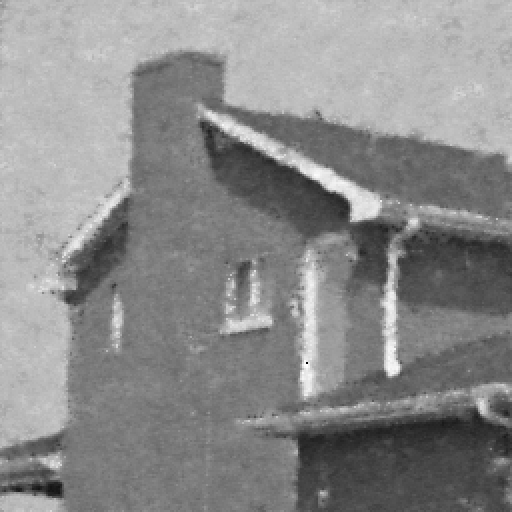

In [12]:
array2pil(np.reshape(predict,[x.shape[1],x.shape[1]])).resize([x.shape[1]*2,x.shape[1]*2])

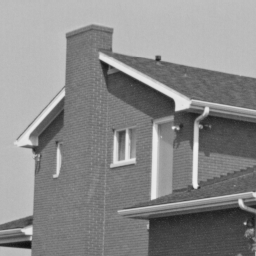

In [11]:
array2pil(np.reshape(y,[x.shape[1],x.shape[1]])).resize([x.shape[1],x.shape[1]])

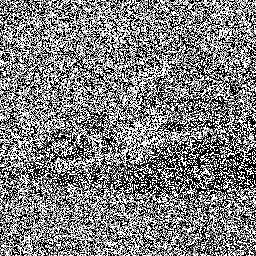

In [60]:
array2pil(np.reshape(x,[x.shape[1],x.shape[1]])).resize([x.shape[1],x.shape[1]])

In [38]:
model.save(model.saver)

In [290]:
import scipy.io
mat = scipy.io.loadmat('test_set2.mat')
x = mat['x']
y = mat['y']
x = [x[i:i+8,:,:] for i in range(0,len(x),8)]
y = [y[i:i+8,:,:] for i in range(0,len(y),8)]
outputs = []
psnrs = []
for x_i,y_i in zip(x,y):
    feed_dict = {model.x:x_i,model.y:y_i}
    output,psnr = model.sess.run([model.G,model.psnr],feed_dict=feed_dict)
    outputs.append(output)
    psnrs.append(psnr)
output = np.reshape(np.array(outputs),[96,256,256])
y = np.reshape(np.array(y),[96,256,256])


In [320]:
x = np.reshape(np.array(x),[96,256,256])

In [292]:
np.mean(psnrs)

35.269184

In [1]:
def show_images2(images):
    plt.figure(figsize=(40,int(80/32*images.shape[0]))) 
    for i in range(images.shape[0]):  
        plt.subplot(images.shape[0]/4,4,i+1)
        plt.imshow(np.squeeze(images[i,:,:]), cmap='gray')

In [14]:
def example_image(im_number,sets):
    im = array2pil(np.squeeze(sets)[im_number,:,:]).convert('RGB')
    draw = ImageDraw.Draw(im)
    draw.rectangle([110, 60, 150, 100], fill=None, outline="#E82C0C")

    pasted_im = array2pil(np.squeeze(sets)[im_number,:,:][60:100,110:150]).resize([256-150,256-150]).convert('RGB')

    im.paste(pasted_im,[150,150,256,256])

    draw = ImageDraw.Draw(im)
    draw.rectangle([150,150,256,256], fill=None, outline="#44E84A")
    return im 


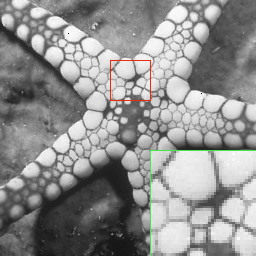

In [364]:
n_i,n_n = 8,7
im = example_image(8*n_i+n_n,output)
im

In [365]:
im.save("butterfly_87_gan.png")

In [16]:
im1 = load_image('/Users/xiejiayu/Desktop/啥都有/学术/MSc/Project/cnn-res-ssim-26.61/noise-adaptive-switching-non-local-means-master/NASNLM/img_1.png')
im2 = load_image('/Users/xiejiayu/Desktop/啥都有/学术/MSc/Project/cnn-res-ssim-26.61/noise-adaptive-switching-non-local-means-master/NASNLM/img_2.png')
im3 = load_image('/Users/xiejiayu/Desktop/啥都有/学术/MSc/Project/cnn-res-ssim-26.61/noise-adaptive-switching-non-local-means-master/NASNLM/img_3.png')

In [21]:
ims = []
for im in [im1,im2,im3]:
    ims.append(np.expand_dims(im,axis=0))
ims = np.concatenate(ims,axis=0)

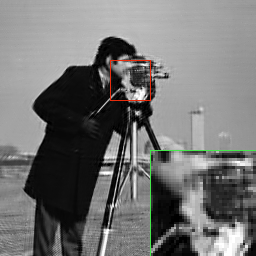

In [30]:
im = example_image(2,ims)
im

In [31]:
im.save("photo_9_Lrank.png")

In [353]:
pre_mf = scipy.io.loadmat("test_2_pre_mf.mat")["pre_mf"]
pre_amf = scipy.io.loadmat("test_2_pre_amf.mat")["pre_amf"]
pre_bda = scipy.io.loadmat("test_2_pre_bda.mat")["pre_bda"]

In [354]:
n_i,n_n = 8,7
n = 8*n_i+n_n
for sets,name in [(pre_mf,"pre_mf"),(pre_amf,"pre_amf"),(pre_bda,"pre_bda")]:
    im = example_image(n,sets)
    im.save("photo_"+str(n)+"_pre_"+name+".png")
    print (name,PSNR(y[n,:,:],sets[n,:,:]))

pre_mf 25.898242497228907
pre_amf 20.364432835363672
pre_bda 32.30455448605947


In [355]:
PSNR(y[n,:,:],np.squeeze(output)[n,:,:])

34.744179749273584

In [201]:
psnrs= [] 
for i in range(120):
    psnrs.append(PSNR(y[i,:,:],np.squeeze(output)[i,:,:]))
psnrs = [psnrs[i:i+10] for i in range(0,len(psnrs),10)]

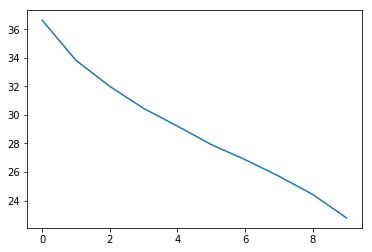

In [206]:
plt.plot(np.mean(np.array(psnrs),axis=0))

In [216]:
psnr_mfs = scipy.io.loadmat("psnr_mfs.mat")["psnr_mfs"]
psnr_amfs = scipy.io.loadmat("psnr_amfs.mat")["psnr_amfs"]
psnr_dbas = scipy.io.loadmat("psnr_dbas.mat")["psnr_dbas"]

psnr_mfs = np.squeeze(psnr_mfs)
psnr_amfs = np.squeeze(psnr_amfs)
psnr_dbas = np.squeeze(psnr_dbas)

psnr_mfs = [psnr_mfs[i:i+10] for i in range(0,len(psnr_mfs),10)]
psnr_amfs = [psnr_amfs[i:i+10] for i in range(0,len(psnr_amfs),10)]
psnr_dbas = [psnr_dbas[i:i+10] for i in range(0,len(psnr_dbas),10)]

In [227]:
bnn_output = scipy.io.loadmat("output.mat")["output"]
bnn_psnrs= [] 
for i in range(120):
    bnn_psnrs.append(PSNR(y[i,:,:],np.squeeze(bnn_output)[i,:,:]))
bnn_psnrs = [bnn_psnrs[i:i+10] for i in range(0,len(bnn_psnrs),10)]

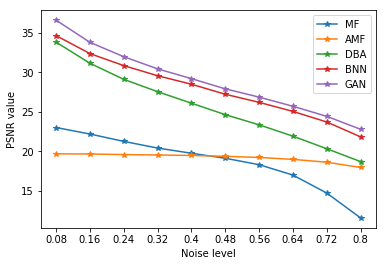

In [274]:
# plt.plot()
plt.plot(np.mean(np.array(psnr_mfs),axis=0),marker="*")
plt.plot(np.mean(np.array(psnr_amfs),axis=0),marker="*")
plt.plot(np.mean(np.array(psnr_dbas),axis=0),marker="*")
plt.plot(np.mean(np.array(bnn_psnrs),axis=0),marker="*")
plt.plot(np.mean(np.array(psnrs),axis=0),marker="*")
plt.legend(labels = ['MF', 'AMF','DBA','BNN','GAN'], loc = 'best')
plt.xlabel('Noise level')
plt.ylabel('PSNR value')

plt.xticks(np.arange(10), [0.08,0.16,0.24,0.32,0.4,0.48,0.56,0.64,0.72,0.8])
plt.savefig("diff_noise.pdf")

